# Project 1, Part 5, Data Visualization



# Included Modules and Packages

Code cell containing your includes for modules and packages

In [25]:
import math
import numpy as np
import pandas as pd

import psycopg2

import gmaps
import gmaps.geojson_geometries

from geographiclib.geodesic import Geodesic

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [26]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)
    

In [27]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [28]:
f = open('gmap_api_key.txt', 'r')
my_api_key = f.read()
f.close()

gmaps.configure(api_key=my_api_key)

# 1.5 Example of a Data Visualization created using Python

The data science team would like for you to create an example of a data visualization using Python from data in a Pandas dataframe containing data from an SQL query.

Write 1 and only 1 query.  Note that the query may have as many subqueries, including "with" clauses, as you wish.  Any query of your choosing.  You can write a query from scratch.  You can use a query from a previous problem in this project.  You can use a query from the labs.  The idea is to come up with a query whose resulting data will make for an excellent quality data visualization. 

Ensure that when you check this Juptyer Notebook into GitHub that the query results in the Pandas dataframe are clearly visible in GitHub.  Note: When a query result has a large number of rows, Pandas will only display the first 5 rows, a row with ellipses, and the last 5 rows. This is ok.

Once you have the data in a Pandas dataframe, you may write as much Python code and use as many code cells as you wish to produce the data visualization.

You may only use Python modules that are currently installed in the Anaconda Docker container.  You may not install additional modules or any other software.

All work must be done in Docker in your VM in AWS.  You may not use any external data visualization systems, such as Tableau, etc.

You may use any code from the labs to pattern your code after, however for the data visualization, you cannot wholesale copy a data visualization from the labs.

Ensure that it is properly titled, including titles for axes if present.

Ensure that when you check this Juptyer Notebook into GitHub that the data visualization is clearly visible.  

If you want to use Google Maps for your data visualization, this is fine, however, the image will not show up in GitHub.  So, just save the image to an image file, include it in the repo, and add a markdown cell to display the image file. Also with Google Maps, do NOT check gmap_api_key.txt into GitHub for security reasons.  If the grader needs to run it, they will supply their own gmap_api_key.txt.


In [29]:
rollback_before_flag = True
rollback_after_flag = True

query = """

/* Creating a temp table called 'store_sales_master' */
with store_sales_master as (
    /* Inside this temp table, selecting the required columns and calculating 
       the number of transactions, items bought, and amount spent per store */
    select 
        c.zip as customer_zip,
        zc.city as customer_city,
        zc.state as customer_state,
        zc.latitude as customer_latitude,
        zc.longitude as customer_longitude,
        s.store_id,
        st.city as store_city,
        st.state as store_state,
        zc_store.latitude as store_latitude,
        zc_store.longitude as store_longitude,
        count(distinct s.sale_id) as total_transactions, 
        sum(li.quantity) as total_items_bought, 
        sum(s.total_amount) as total_amount_spent,
        /* Adding the 'out_of_city' column */
        case 
            when zc.state = st.state and zc.city != st.city then 'Yes' 
            else 'No' 
        end as out_of_city,
        /* Adding the 'out_of_state' column */
        case 
            when zc.state != st.state then 'Yes' 
            else 'No' 
        end as out_of_state
    from 
        customers c
    /* Joining with 'sales' table on 'customer_id' */
    join 
        sales s on c.customer_id = s.customer_id
    /* Joining with 'line_items' table on 'sale_id' and 'store_id' */
    join 
        line_items li on s.sale_id = li.sale_id and s.store_id = li.store_id
    /* Joining with 'stores' table on 'store_id' */
    join 
        stores st on s.store_id = st.store_id
    /* Joining with 'zip_codes' table to compare customer zip with store city zip and to get the customer city and state */
    join 
        zip_codes zc on c.zip = zc.zip
    /* Joining with 'zip_codes' table again to get store city zip and to get the store city latitude and longitude */
    join
        zip_codes zc_store on st.zip = zc_store.zip
    /* Grouping by 'customer_zip', 'store_id', 'store_city', 'store_state', 'customer_city', 'customer_state' */
    group by 
        c.zip, 
        zc.city,
        zc.state,
        zc.latitude,
        zc.longitude,
        s.store_id, 
        st.city, 
        st.state,
        zc_store.latitude,
        zc_store.longitude,
        zc.zip
)

/* Now, selecting the computed metrics and the newly created columns 'out_of_city' and 'out_of_state' from 'store_sales_master' temp table */
select 
    customer_zip,
    customer_city,
    customer_state,
    customer_latitude,
    customer_longitude,
    store_id,
    store_city,
    store_state,
    store_latitude,
    store_longitude,
    total_transactions, 
    round(total_items_bought / total_transactions, 2) as avg_items_per_transaction, 
    round(total_amount_spent / total_transactions, 2) as avg_amount_per_transaction,
    out_of_city,
    out_of_state
from 
    store_sales_master;


"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,customer_zip,customer_city,customer_state,customer_latitude,customer_longitude,store_id,store_city,store_state,store_latitude,store_longitude,total_transactions,avg_items_per_transaction,avg_amount_per_transaction,out_of_city,out_of_state
0,33004,Dania,FL,26.0579,-80.1385,4,Miami,FL,25.7632,-80.1846,46,5.65,303.91,Yes,No
1,33009,Hallandale,FL,25.9857,-80.1479,4,Miami,FL,25.7632,-80.1846,1438,6.08,328.15,Yes,No
2,33010,Hialeah,FL,25.8330,-80.2787,4,Miami,FL,25.7632,-80.1846,6468,5.50,287.86,Yes,No
3,33012,Hialeah,FL,25.8656,-80.3025,4,Miami,FL,25.7632,-80.1846,4509,5.34,278.83,Yes,No
4,33013,Hialeah,FL,25.8623,-80.2703,4,Miami,FL,25.7632,-80.1846,2450,5.44,285.15,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,98403,Tacoma,WA,47.2660,-122.4585,2,Seattle,WA,47.6115,-122.2918,65,5.98,328.62,Yes,No
546,98407,Tacoma,WA,47.2886,-122.5113,2,Seattle,WA,47.6115,-122.2918,114,6.29,341.47,Yes,No
547,98416,Tacoma,WA,47.2625,-122.4812,2,Seattle,WA,47.6115,-122.2918,43,6.14,333.77,Yes,No
548,98421,Tacoma,WA,47.2592,-122.3995,2,Seattle,WA,47.6115,-122.2918,228,6.03,325.74,Yes,No


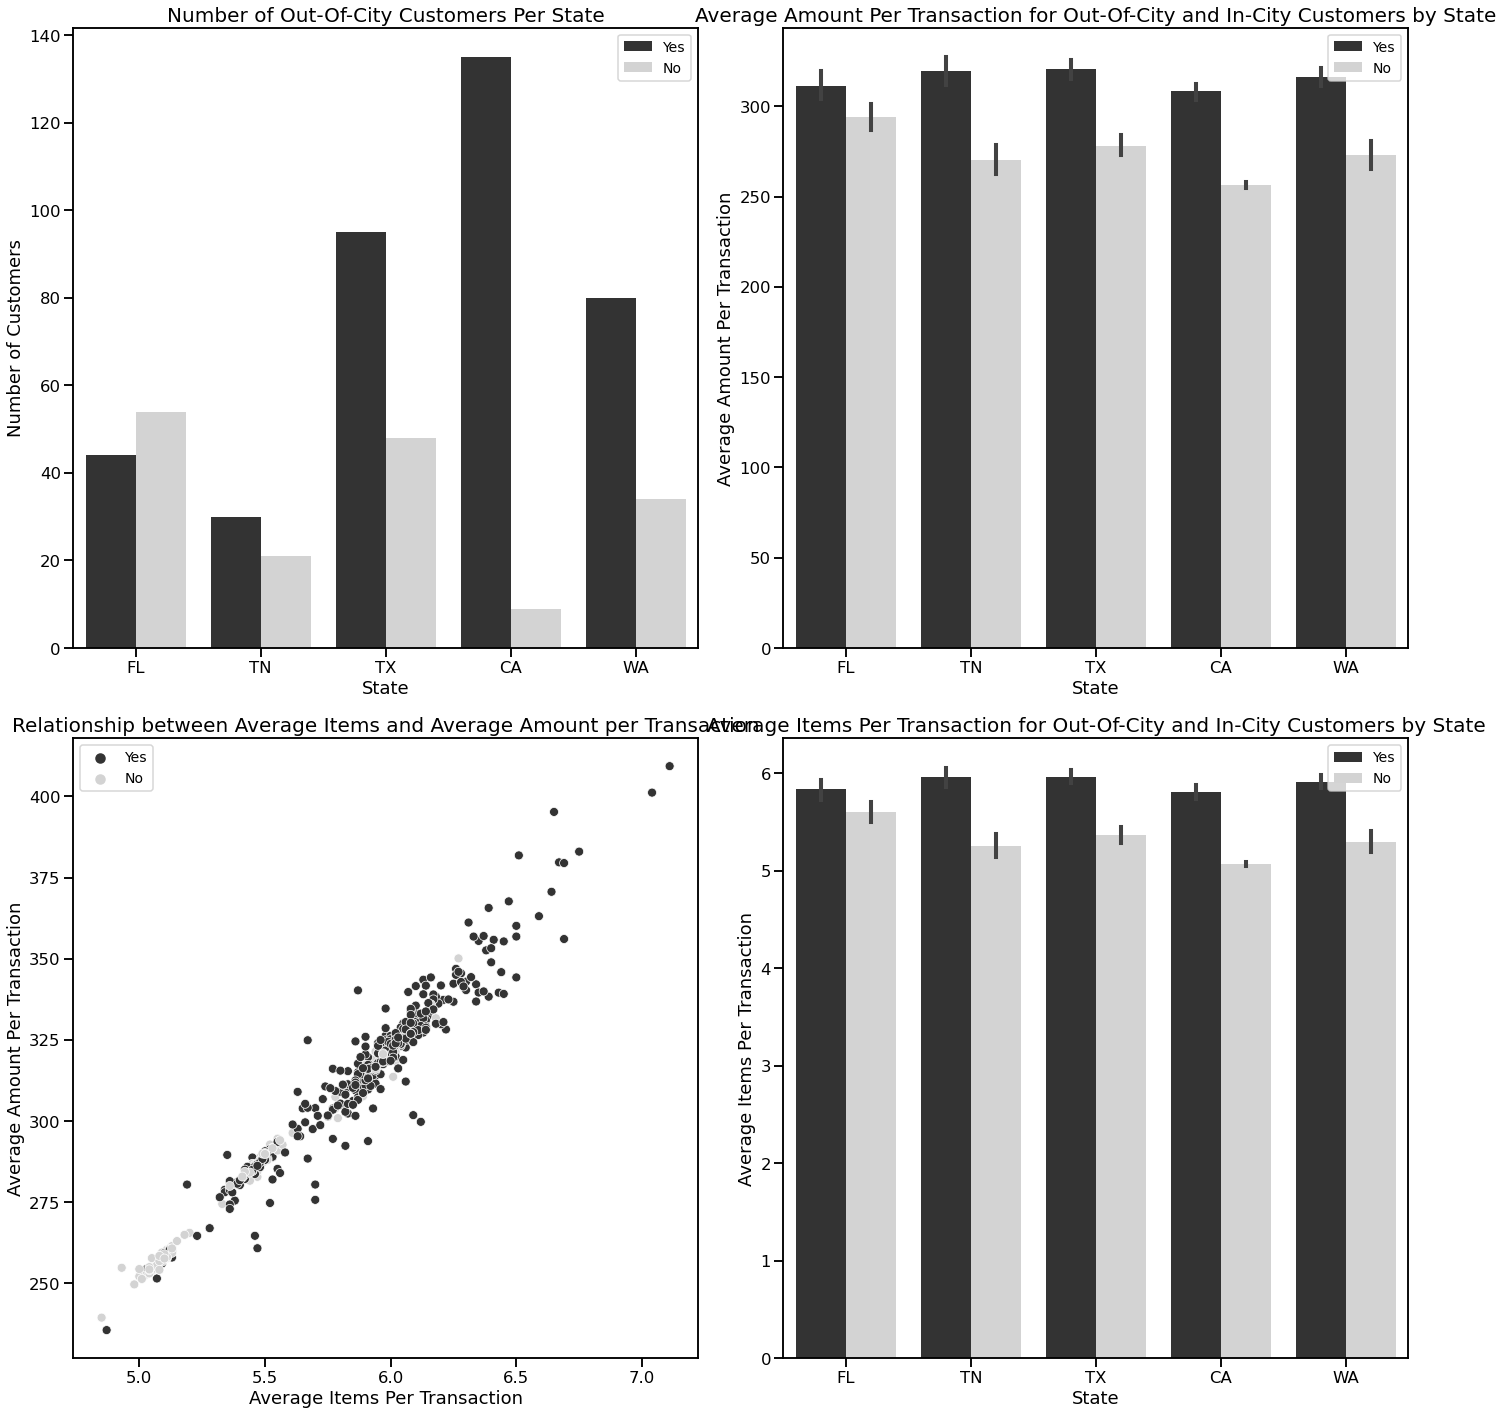

In [30]:
sns.set_context("talk")  # Increases the size of the labels, ticks and title

fig, ax = plt.subplots(2, 2, figsize=(20, 20)) 

# Query 1
sns.countplot(data=df, x='customer_state', hue='out_of_city', ax=ax[0, 0], palette=['#333333', 'lightgray'])
ax[0, 0].set_title('Number of Out-Of-City Customers Per State', fontsize=20)
ax[0, 0].set_xlabel('State', fontsize=18)
ax[0, 0].set_ylabel('Number of Customers', fontsize=18)
ax[0, 0].legend(fontsize=14)

# Query 2
sns.barplot(data=df, x='customer_state', y='avg_amount_per_transaction', hue='out_of_city', ax=ax[0, 1], palette=['#333333', 'lightgray'])
ax[0, 1].set_title('Average Amount Per Transaction for Out-Of-City and In-City Customers by State', fontsize=20)
ax[0, 1].set_xlabel('State', fontsize=18)
ax[0, 1].set_ylabel('Average Amount Per Transaction', fontsize=18)
ax[0, 1].legend(fontsize=14)

# New Query 3
sns.scatterplot(data=df, x='avg_items_per_transaction', y='avg_amount_per_transaction', hue='out_of_city', ax=ax[1, 0], palette=['#333333', 'lightgray'])
ax[1, 0].set_title('Relationship between Average Items and Average Amount per Transaction', fontsize=20)
ax[1, 0].set_xlabel('Average Items Per Transaction', fontsize=18)
ax[1, 0].set_ylabel('Average Amount Per Transaction', fontsize=18)
ax[1, 0].legend(fontsize=14)

# Query 4
sns.barplot(data=df, x='customer_state', y='avg_items_per_transaction', hue='out_of_city', ax=ax[1, 1], palette=['#333333', 'lightgray'])
ax[1, 1].set_title('Average Items Per Transaction for Out-Of-City and In-City Customers by State', fontsize=20)
ax[1, 1].set_xlabel('State', fontsize=18)
ax[1, 1].set_ylabel('Average Items Per Transaction', fontsize=18)
ax[1, 1].legend(fontsize=14)

plt.tight_layout()
plt.show()


---

### Markers for each store

> You could put a marker on the map for each store. This gives you a sense of where your stores are located geographically.

In [10]:
store_locations = df[['store_latitude', 'store_longitude']]
store_layer = gmaps.marker_layer(store_locations)
fig = gmaps.figure()
fig.add_layer(store_layer)
fig


Figure(layout=FigureLayout(height='420px'))

### Heatmap of customer locations

> This can help you understand the geographic distribution of your customers. If the heatmap is denser around your store locations, that suggests your customers are mostly local

In [11]:
customer_locations = df[['customer_latitude', 'customer_longitude']]
heatmap_layer = gmaps.heatmap_layer(customer_locations)
fig = gmaps.figure()
fig.add_layer(heatmap_layer)
fig


Figure(layout=FigureLayout(height='420px'))

---

### Lines between stores and customers

> For each transaction, draw a line between the store and the customer's location. This gives you a sense of how far customers are traveling to each store. This can be a lot of lines if you have many transactions, so you might want to limit it to a subset of the data or adjust the line opacity.

In [15]:
df_CA = df[(df['store_state'] == 'CA') | (df['customer_state'] == 'CA')]
df_CA

,customer_zip,customer_city,customer_state,customer_latitude,customer_longitude,store_id,store_city,store_state,store_latitude,store_longitude,total_transactions,avg_items_per_transaction,avg_amount_per_transaction,out_of_city,out_of_state
292,94002,Belmont,CA,37.5135,-122.2991,1,Berkeley,CA,37.8652,-122.2382,143,6.13,327.27,Yes,No
293,94005,Brisbane,CA,37.6887,-122.4080,1,Berkeley,CA,37.8652,-122.2382,1220,6.13,331.65,Yes,No
294,94010,Burlingame,CA,37.5693,-122.3653,1,Berkeley,CA,37.8652,-122.2382,192,5.90,313.25,Yes,No
295,94014,Daly City,CA,37.6909,-122.4475,1,Berkeley,CA,37.8652,-122.2382,1226,5.89,312.64,Yes,No
296,94015,Daly City,CA,37.6812,-122.4805,1,Berkeley,CA,37.8652,-122.2382,108,6.43,339.56,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,94963,San Geronimo,CA,38.0138,-122.6703,1,Berkeley,CA,37.8652,-122.2382,174,5.92,316.41,Yes,No
432,94964,San Quentin,CA,37.9431,-122.4918,1,Berkeley,CA,37.8652,-122.2382,1072,6.18,329.98,Yes,No
433,94965,Sausalito,CA,37.8499,-122.5236,1,Berkeley,CA,37.8652,-122.2382,1156,6.10,328.16,Yes,No
434,94970,Stinson Beach,CA,37.9145,-122.6469,1,Berkeley,CA,37.8652,-122.2382,187,5.85,305.01,Yes,No


In [18]:
store_cities = {
    1: {"name": "Berkeley", "center": (37.8555, -122.2604), "zoom": 9, "color": "#006400"},
    2: {"name": "Seattle", "center": (47.6114, -122.3214), "zoom": 9, "color": "#8B4513"},
    3: {"name": "Dallas", "center": (32.7958, -96.8015), "zoom": 9, "color": "#B22222"},
    4: {"name": "Miami", "center": (25.772, -80.1891), "zoom": 9, "color": "#8A2BE2"},
    5: {"name": "Nashville", "center": (36.1568, -86.7881), "zoom": 9, "color": "#20B2AA"},
}

In [20]:
store_id = 1
info = store_cities[store_id]
df_store = df[df['store_id'] == store_id]

lines = []
for idx, row in df_store.iterrows():
    customer_location = (row['customer_latitude'], row['customer_longitude'])
    store_location = (row['store_latitude'], row['store_longitude'])
    lines.append(gmaps.Line(start=customer_location, end=store_location, stroke_weight=1, stroke_color=info['color']))

drawing = gmaps.drawing_layer(features=lines)
fig = gmaps.figure(center=info["center"], zoom_level=info["zoom"])
fig.add_layer(drawing)

# Display the figure
print(f"Customer connections for Store in {info['name']}:")
display(fig)


Customer connections for Store in Berkeley:


Figure(layout=FigureLayout(height='420px'))

In [21]:
store_id = 2
info = store_cities[store_id]
df_store = df[df['store_id'] == store_id]

lines = []
for idx, row in df_store.iterrows():
    customer_location = (row['customer_latitude'], row['customer_longitude'])
    store_location = (row['store_latitude'], row['store_longitude'])
    lines.append(gmaps.Line(start=customer_location, end=store_location, stroke_weight=1, stroke_color=info['color']))

drawing = gmaps.drawing_layer(features=lines)
fig = gmaps.figure(center=info["center"], zoom_level=info["zoom"])
fig.add_layer(drawing)

# Display the figure
print(f"Customer connections for Store in {info['name']}:")
display(fig)


Customer connections for Store in Seattle:


Figure(layout=FigureLayout(height='420px'))

In [22]:
store_id = 3
info = store_cities[store_id]
df_store = df[df['store_id'] == store_id]

lines = []
for idx, row in df_store.iterrows():
    customer_location = (row['customer_latitude'], row['customer_longitude'])
    store_location = (row['store_latitude'], row['store_longitude'])
    lines.append(gmaps.Line(start=customer_location, end=store_location, stroke_weight=1, stroke_color=info['color']))

drawing = gmaps.drawing_layer(features=lines)
fig = gmaps.figure(center=info["center"], zoom_level=info["zoom"])
fig.add_layer(drawing)

# Display the figure
print(f"Customer connections for Store in {info['name']}:")
display(fig)


Customer connections for Store in Dallas:


Figure(layout=FigureLayout(height='420px'))

In [23]:
store_id = 4
info = store_cities[store_id]
df_store = df[df['store_id'] == store_id]

lines = []
for idx, row in df_store.iterrows():
    customer_location = (row['customer_latitude'], row['customer_longitude'])
    store_location = (row['store_latitude'], row['store_longitude'])
    lines.append(gmaps.Line(start=customer_location, end=store_location, stroke_weight=1, stroke_color=info['color']))

drawing = gmaps.drawing_layer(features=lines)
fig = gmaps.figure(center=info["center"], zoom_level=info["zoom"])
fig.add_layer(drawing)

# Display the figure
print(f"Customer connections for Store in {info['name']}:")
display(fig)


Customer connections for Store in Miami:


Figure(layout=FigureLayout(height='420px'))

In [24]:
store_id = 5
info = store_cities[store_id]
df_store = df[df['store_id'] == store_id]

lines = []
for idx, row in df_store.iterrows():
    customer_location = (row['customer_latitude'], row['customer_longitude'])
    store_location = (row['store_latitude'], row['store_longitude'])
    lines.append(gmaps.Line(start=customer_location, end=store_location, stroke_weight=1, stroke_color=info['color']))

drawing = gmaps.drawing_layer(features=lines)
fig = gmaps.figure(center=info["center"], zoom_level=info["zoom"])
fig.add_layer(drawing)

# Display the figure
print(f"Customer connections for Store in {info['name']}:")
display(fig)


Customer connections for Store in Nashville:


Figure(layout=FigureLayout(height='420px'))